In [1]:
# Since the best way to learn/hack on Dask seems to be by directly editing the installed source code,
# let's have it all reloaded automatically.
#

%load_ext autoreload
%aimport -dask.utils

%autoreload 2

In [2]:
# To set up an environment for this experiment, run:
#    mamba create -n lsd2-2023 -c conda-forge dask pyarrow healpy ipykernel python-graphviz rich ipywidgets python-snappy
# and then create a Jupyter kernel w. something like:
#    conda activate lsd2-2023
#    python -m ipykernel install --user --name lsd2-2023 --display-name "LSD2 (2023)"
#

import dask
import dask.dataframe as dd
import pandas as pd
import numpy as np
import healpy as hp

import lsdb
import hipscat as hc

print(f"{dask.__version__=}")
print(f"{pd.__version__=}")
print(f"{np.__version__=}")
print(f"{hp.__version__=}")
print(f"{lsdb.__version__=}")
print(f"{hc.__version__=}")


dask.__version__='2022.12.1'
pd.__version__='1.5.2'
np.__version__='1.24.0'
hp.__version__='1.16.1'
lsdb.__version__='0.0.1dev'
hc.__version__='0.0.1dev'


Configure Dask:

In [3]:
# from dask.diagnostics import ProgressBar
#ProgressBar().register()

In [4]:
dask.config.set(temporary_directory='/epyc/ssd/users/mjuric/tmp')
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})

# silence incredibly annoying INFO/WARN gc messages
# FIXME: follow https://dask.discourse.group/t/disable-dask-worker-logs-from-printing-on-console-and-write-to-file/408/4
#  to implement a more fine-grained solution
dask.config.set({'logging.distributed': 'error'});

In [5]:
import glob

inprefix = "/epyc/projects3/sam_hipscat/output/gaia_real"
outprefix = "/epyc/projects3/mjuric_hipscat/foo"

## Demo

Launch Dask cluster:

In [6]:
from dask.distributed import Client
client = Client(n_workers=16, threads_per_worker=1, memory_limit="24G", dashboard_address="localhost:23456")

port = client._get_scheduler_info()[1]["services"]["dashboard"]
print("Tunnel SSH command:")
print(f"ssh -L {port}:localhost:{port} epyc.astro.washington.edu")

client

Tunnel SSH command:
ssh -L 23456:localhost:23456 epyc.astro.washington.edu


<Client: 'tcp://127.0.0.1:39014' processes=16 threads=16, memory=357.63 GiB>

Full self-driving:

In [8]:
%%time
! rm -fr "{outprefix}"

# Figure out the ideal partitioning
incat = glob.glob(f'{inprefix}/*/*/catalog.parquet')[:5]
ddf = dd.read_parquet(incat)

ldf = lsdb.from_dask(ddf)
ldf.to_hipscat(outprefix);

CPU times: user 6.74 s, sys: 2.56 s, total: 9.3 s
Wall time: 20.8 s


{'opix': {0: [0, 6], 2: [65, 66, 67]}, 'threshold': 1000000, 'lon': 'ra', 'lat': 'dec', 'orders': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint64)}

A bit more driver input:

In [9]:
%%time
! rm -fr "{outprefix}"

# Figure out the ideal partitioning
incat = glob.glob(f'{inprefix}/*/*/catalog.parquet')[:5]
counts_df = dd.read_parquet(incat, columns=["ra", "dec"])
cat_df    = dd.read_parquet(incat)

ldf = lsdb.from_dask(cat_df, counts_df=counts_df)
ldf.to_hipscat(outprefix);

CPU times: user 5.93 s, sys: 2.5 s, total: 8.43 s
Wall time: 18.4 s


{'opix': {0: [0, 6], 2: [65, 66, 67]}, 'threshold': 1000000, 'lon': 'ra', 'lat': 'dec', 'orders': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint64)}

Now from CSV:

In [13]:
%%time
! rm -fr "{outprefix}"

gaiacsv = glob.glob("/epyc/data/gaia_dr3/csv/GaiaSource/GaiaSource_*.csv.gz")

# FIXME: this is very brittle. column datatypes should be loaded from Gaia's CSV header (or elsewhere).
# also see https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options
ddf = dd.read_csv(gaiacsv, comment="#", blocksize=None,
                  dtype={  'phot_bp_n_blended_transits':      'float64',
                           'phot_bp_n_contaminated_transits': 'float64',
                           'phot_rp_n_blended_transits':      'float64',
                           'phot_rp_n_contaminated_transits': 'float64',
                            'phot_proc_mode':                 'float64'
                        })
ldf = lsdb.from_dask(ddf)
ldf.to_hipscat(outprefix);

/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/dask/dataframe/io/csv.py:194: DtypeWarning: Columns (151) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/dask/dataframe/io/csv.py:194: DtypeWarning: Columns (151) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/dask/dataframe/io/csv.py:194: DtypeWarning: Columns (151) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/dask/dataframe/io/csv.py:194: DtypeWarning: Columns (151) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-

2023-01-24 13:43:31,424 - distributed.worker.memory - WARNING - gc.collect() took 1.066s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 13:46:50,637 - distributed.worker.memory - WARNING - gc.collect() took 1.055s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 13:52:12,149 - distributed.worker.memory - WARNING - gc.collect() took 1.127s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 13:52:15,129 - distributed.worker.memory - WARNING - gc.collect() took 1.132s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 13:53:10,326 - distributed.worker.memory - WARNING - gc.collect() took 1.

2023-01-24 14:40:51,027 - distributed.worker.memory - WARNING - gc.collect() took 1.485s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 14:41:00,719 - distributed.worker.memory - WARNING - gc.collect() took 1.295s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 14:42:32,526 - distributed.worker.memory - WARNING - gc.collect() took 1.018s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 14:43:30,265 - distributed.worker.memory - WARNING - gc.collect() took 1.564s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 14:46:05,122 - distributed.worker.memory - WARNING - gc.collect() took 1.

/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/dask/dataframe/io/csv.py:194: DtypeWarning: Columns (151) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
2023-01-24 15:22:47,944 - distributed.worker.memory - WARNING - gc.collect() took 1.823s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 15:23:06,432 - distributed.worker.memory - WARNING - gc.collect() took 1.263s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 15:24:36,227 - distributed.worker.memory - WARNING - gc.collect() took 1.370s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 15:25:06,031 - distributed.worker.memory - WARNING - gc.collect

2023-01-24 15:38:32,593 - distributed.worker.memory - WARNING - gc.collect() took 8.092s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 15:38:49,185 - distributed.worker.memory - WARNING - gc.collect() took 4.971s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 15:38:50,808 - distributed.worker.memory - WARNING - gc.collect() took 4.606s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 15:38:51,874 - distributed.worker.memory - WARNING - gc.collect() took 4.239s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 15:38:51,885 - distributed.worker.memory - WARNING - Worker is at 81% mem

2023-01-24 15:41:18,002 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 15:41:23,556 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 15:41:25,166 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 15:41:25,833 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 15:41:27,276 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 15:41:30,032 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 15:41:31,355 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-01-24 15:41:35,972 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 15:42:57,903 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 15:43:01,113 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 15:43:01,457 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 15:43:04,360 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 15:43:05,737 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 15:43:11,941 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 15:43:12,129 - distributed.worker.memory - WARNING - gc.collect() took 6.998s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks mig

2023-01-24 15:44:12,101 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 15:44:14,646 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:42148 -> tcp://127.0.0.1:46091
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/worker

2023-01-24 15:44:26,020 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 15:44:28,138 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 15:44:29,629 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:46308
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback

2023-01-24 15:44:56,130 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 15:44:58,812 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 15:44:58,812 - distributed.worker.memory - WARNING - gc.collect() took 6.191s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 15:45:00,745 - distributed.worker.memory - WARNING - gc.collect() took 3.278s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 15:45:01,084 - distributed.worker.memory - WARNING - gc.collect() took 3.225s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 15:45:01,558 - distributed.utils_perf - WA

2023-01-24 15:46:22,446 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 15:46:22,446 - distributed.worker.memory - WARNING - gc.collect() took 4.340s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 15:46:23,442 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 15:46:24,738 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:38746 -> tcp://127.0.0.1:39191
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 1138, in read_fr

2023-01-24 15:47:11,227 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 15:47:12,740 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-01-24 15:47:14,228 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 15:47:14,241 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 15:47:14,381 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 15:47:15,160 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 15:47:16,576 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 15:47:18,778 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 15:48:27,682 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 15:48:28,018 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 15:48:29,652 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 15:48:30,172 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 15:48:30,446 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 15:48:30,518 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 15:48:33,567 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 15:48:34,639 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 15:49:23,152 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 15:49:23,706 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 15:49:23,831 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 15:49:23,936 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 15:49:27,711 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 15:49:28,964 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-01-24 15:49:32,525 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 15:49:32,525 - distributed.worker.memory - WARNING - gc.collect() took 4.079s. 

2023-01-24 15:50:32,187 - distributed.worker.memory - WARNING - Worker is at 76% memory usage. Resuming worker. Process memory: 17.02 GiB -- Worker memory limit: 22.35 GiB
2023-01-24 15:50:32,423 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 15:50:32,923 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 15:50:34,734 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 15:50:35,519 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 15:50:37,831 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 15:50:39,400 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 15:50:41,273 - distributed.utils_perf

2023-01-24 15:51:33,285 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-01-24 15:51:33,655 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 15:51:36,164 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 15:51:37,721 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 15:51:37,952 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 15:51:38,844 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 15:51:40,480 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-01-24 15:51:41,211 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 15:52:28,198 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 15:52:29,006 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 15:52:29,038 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 15:52:29,976 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 15:52:31,391 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 15:52:32,315 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 15:52:33,008 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 15:52:33,540 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 15:53:20,344 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 15:53:21,801 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 15:53:21,804 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 15:53:21,981 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 15:53:23,265 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 15:53:24,947 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 15:53:24,948 - distributed.worker.memory - WARNING - gc.collect() took 5.198s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks mig

2023-01-24 15:54:17,144 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 15:54:17,243 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 15:54:17,915 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-01-24 15:54:17,919 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-01-24 15:54:18,461 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 15:54:19,788 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 15:54:19,858 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 15:54:19,897 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 15:54:59,433 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 15:54:59,911 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 15:54:59,973 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 15:55:00,227 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 15:55:01,876 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 15:55:03,378 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 15:55:05,296 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 15:55:05,546 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 15:55:41,645 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 15:55:42,578 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:39191 -> tcp://127.0.0.1:40631
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/worker

2023-01-24 15:56:06,306 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 15:56:07,636 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 15:56:08,341 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 15:56:10,090 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 15:56:11,104 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 15:56:11,117 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 15:56:11,233 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 15:56:12,188 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 15:56:27,656 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-01-24 15:56:29,093 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 15:56:30,908 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 15:56:32,001 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 15:56:34,011 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 15:56:35,012 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 15:56:37,587 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 15:56:38,192 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 15:57:15,457 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 15:57:15,732 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 15:57:16,741 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 15:57:17,259 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 15:57:17,538 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 15:57:18,754 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 15:57:19,274 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 15:57:20,992 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 15:57:40,223 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 15:57:41,077 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 15:57:41,116 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 15:57:41,870 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 15:57:43,569 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 15:57:44,415 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 15:57:45,087 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 15:57:45,498 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 15:57:51,038 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:40631 -> tcp://127.0.0.1:46308
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/worker.py", line 1767, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

2023-01-24 15:57:55,413 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 15:57:55,825 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 15:57:56,048 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 15:57:58,132 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 15:58:01,308 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 15:58:01,857 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 15:58:02,461 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 15:58:05,811 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 15:58:55,033 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 15:58:56,154 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 15:58:56,761 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 15:58:56,979 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 15:58:57,785 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 15:58:59,249 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 15:59:00,380 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 15:59:00,827 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 15:59:41,926 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 15:59:43,403 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 15:59:44,549 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 15:59:44,675 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 15:59:45,252 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 15:59:45,576 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 15:59:45,598 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 15:59:47,569 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:00:25,807 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:00:26,187 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:00:26,690 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:00:26,813 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:00:27,735 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:00:29,326 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:00:29,879 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 16:00:30,883 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:01:22,396 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:01:23,495 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 16:01:23,821 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:01:23,910 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:01:24,599 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:01:26,198 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:01:28,763 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:01:30,417 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:02:23,136 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:02:25,266 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:02:25,387 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:02:25,522 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 16:02:25,874 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:02:26,335 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:02:26,596 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:02:27,028 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:03:05,130 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:03:05,303 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-24 16:03:06,268 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:03:06,816 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:03:07,942 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:03:08,561 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:03:10,032 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:03:10,543 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:03:44,229 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:03:45,879 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:03:46,224 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:03:46,890 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:03:50,453 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:03:50,791 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:03:51,421 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:03:51,675 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:04:05,856 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:43752
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/worker.py", line 2058, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc

2023-01-24 16:04:41,655 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:04:44,761 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:04:45,674 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:04:48,273 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:04:48,309 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:04:48,686 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 16:04:49,580 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:04:50,427 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:05:31,366 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:05:33,533 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:05:33,777 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 16:05:33,961 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:05:34,805 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:05:34,989 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 16:05:35,414 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:05:36,041 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:06:18,389 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:06:20,412 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:06:22,708 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:06:22,888 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 16:06:24,741 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 16:06:26,715 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:06:27,055 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 16:06:27,069 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:07:15,858 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:07:18,093 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:07:18,153 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:07:19,246 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:07:19,372 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:07:19,649 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 16:07:19,763 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:07:20,015 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:08:14,324 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:08:14,452 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:08:14,625 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:08:14,801 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:08:15,153 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:08:15,498 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 16:08:16,977 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:08:17,233 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:08:58,821 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 16:08:58,954 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:09:00,546 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:09:01,765 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:09:01,936 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:09:02,683 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:09:03,058 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 16:09:05,023 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:09:49,698 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 16:09:50,103 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:09:50,366 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:09:50,839 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:09:50,982 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:09:51,705 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:09:52,704 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:09:53,880 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:10:50,052 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:10:50,285 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:10:51,898 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:10:52,507 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 16:10:54,024 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:10:55,212 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:10:55,277 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:10:55,509 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:11:57,723 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:11:58,311 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:11:58,608 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 16:11:58,677 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 16:11:58,814 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 16:11:58,895 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:11:58,907 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 16:11:59,204 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:12:45,989 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 16:12:46,566 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:12:47,288 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 16:12:48,485 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:12:52,143 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-24 16:12:52,411 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:12:55,103 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 16:12:55,410 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:13:27,770 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:13:28,083 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:13:28,083 - distributed.worker.memory - WARNING - gc.collect() took 2.897s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 16:13:28,676 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:13:29,970 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:13:32,049 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 16:13:33,748 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (thresho

2023-01-24 16:14:15,796 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 16:14:15,856 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:14:15,935 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:14:16,214 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-24 16:14:16,484 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:14:16,510 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 16:14:17,349 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:14:18,054 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:15:05,234 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:15:05,771 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:15:06,132 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 16:15:07,086 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:15:07,557 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 16:15:10,157 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:15:10,327 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 16:15:10,700 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:15:59,908 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:16:00,563 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:16:01,325 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 16:16:01,553 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:16:01,836 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:16:02,920 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:16:03,290 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:16:03,900 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:16:45,718 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:16:49,034 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:16:49,048 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:16:49,153 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:16:51,744 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 16:16:51,939 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:16:54,359 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:16:55,257 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:17:30,916 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:17:31,970 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 16:17:32,581 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:17:33,055 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 16:17:33,119 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 16:17:34,887 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:17:37,815 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:17:37,901 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:18:38,221 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 16:18:39,671 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 16:18:42,402 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:18:44,053 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 16:18:44,295 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:18:44,685 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:18:45,315 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:18:47,736 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:19:19,782 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:19:19,891 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:19:20,281 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:19:21,638 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:19:22,801 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:19:22,882 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 16:19:22,916 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:19:23,286 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:20:04,808 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:20:05,383 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:20:06,939 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:20:07,120 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:20:07,150 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:20:07,238 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:20:07,537 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:20:08,392 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:20:51,327 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:20:51,803 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:20:52,129 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 16:20:52,799 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:20:53,812 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 16:20:54,497 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:20:55,101 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:20:55,159 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:21:42,223 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:21:42,948 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:21:45,445 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:21:45,554 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:21:45,586 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:21:46,018 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:21:46,059 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:21:47,300 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:22:31,677 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:22:32,646 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 16:22:32,675 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:22:33,441 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:22:33,915 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:22:37,149 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:22:37,196 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:22:37,386 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:23:20,094 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:23:20,334 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:23:22,556 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:23:22,618 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:23:23,093 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:23:23,252 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:23:23,407 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 16:23:25,437 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:24:09,837 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:24:10,129 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:24:11,857 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:24:12,113 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:24:13,786 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:24:14,506 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 16:24:14,910 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:24:15,102 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:24:41,347 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:24:42,010 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:24:42,056 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:24:43,036 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:24:43,473 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:24:44,504 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 16:24:46,513 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:24:48,511 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:25:17,731 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:25:18,515 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:25:19,758 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 16:25:20,345 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:25:20,462 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 16:25:20,946 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:25:21,041 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:25:21,228 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:26:23,614 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:26:24,190 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:26:25,360 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:26:27,366 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:26:27,384 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:26:29,111 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:26:29,419 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:26:29,433 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:27:15,278 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:27:16,204 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:27:16,629 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:27:17,380 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:27:20,251 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:27:20,481 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:27:23,007 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:27:23,412 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:28:15,757 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:28:15,769 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:28:15,879 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:28:16,109 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:28:16,443 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:28:16,705 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 16:28:17,449 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:28:17,563 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:28:30,207 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:28:31,198 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:28:31,543 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:28:31,623 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 16:28:31,666 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:28:32,468 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:28:32,800 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:28:34,054 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:29:21,523 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:29:21,943 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:29:22,277 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:29:22,951 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 16:29:23,933 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:29:25,012 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:29:25,457 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 16:29:25,659 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:30:05,216 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:30:06,480 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 16:30:09,110 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:30:09,363 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:30:09,963 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:30:11,053 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:30:11,618 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:30:11,768 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:31:14,446 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:31:14,659 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 16:31:14,890 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:31:15,610 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:31:15,714 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:31:15,981 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:31:16,898 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:31:18,163 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:32:12,085 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:32:12,468 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 16:32:12,469 - distributed.worker.memory - WARNING - gc.collect() took 7.870s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 16:32:12,591 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:32:14,552 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:32:14,868 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:32:16,115 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (thresho

2023-01-24 16:33:03,669 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:33:05,245 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:33:07,072 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:33:07,532 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:33:08,155 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:33:08,320 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 16:33:08,761 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:33:09,847 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:34:05,607 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 16:34:06,315 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:34:06,614 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:34:07,029 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:34:08,539 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:34:09,105 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:34:09,233 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:34:09,345 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:35:07,701 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:35:07,739 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:35:08,955 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:35:09,252 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:35:11,224 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:35:11,494 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:35:12,203 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:35:12,251 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:35:48,205 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:35:53,081 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:35:53,545 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 16:35:54,050 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:35:54,446 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:35:55,316 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:35:55,448 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:43078
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python

2023-01-24 16:36:19,870 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:36:19,875 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:36:20,659 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:36:20,744 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 16:36:22,087 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:36:22,318 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:36:23,071 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:36:23,335 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:37:26,910 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:37:27,459 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:37:28,045 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 16:37:28,142 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:37:28,268 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:37:30,817 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:37:32,455 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:37:34,522 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:38:20,085 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 16:38:21,170 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:38:22,554 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:38:24,481 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:38:27,866 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:38:28,312 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:38:28,856 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:38:30,178 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:39:13,016 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 16:39:15,161 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:39:15,713 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 16:39:15,858 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:39:16,278 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:39:16,682 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:39:18,495 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:39:18,653 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:40:05,343 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:40:06,020 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:40:06,702 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:40:06,712 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:40:08,367 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:40:08,555 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:40:08,645 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:40:08,755 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:40:39,698 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:40:39,820 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:40:39,823 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:40:40,311 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:40:40,769 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 16:40:41,034 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 16:40:41,982 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:40:43,278 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:41:37,309 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:41:37,780 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:41:39,913 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:41:40,348 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:41:42,490 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 16:41:42,737 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:41:44,954 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:41:47,361 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:42:33,039 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:42:33,140 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:42:33,465 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 16:42:33,816 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:42:36,148 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:42:36,665 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 16:42:37,147 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:42:37,521 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:43:24,762 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:43:25,368 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:43:26,249 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 16:43:26,935 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 16:43:28,567 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:43:30,033 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:43:31,524 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:43:33,118 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:44:16,706 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:44:16,732 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:44:16,922 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:44:17,320 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:44:18,622 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:44:19,606 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 16:44:19,672 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:44:19,745 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:45:00,736 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:45:01,542 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:45:02,548 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:45:03,122 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:45:03,203 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:45:07,077 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:45:07,707 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:45:08,433 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:45:47,648 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:45:47,833 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:45:48,038 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:45:48,049 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 16:45:48,054 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:45:48,117 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:45:48,435 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:45:49,204 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:46:42,869 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:46:44,393 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:46:44,734 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 16:46:44,998 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 16:46:45,586 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:46:46,218 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:46:46,374 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:46:46,425 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:47:31,967 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:47:35,275 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:47:37,966 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 16:47:39,948 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:47:42,184 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:47:42,568 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:47:42,738 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:47:44,503 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:48:23,199 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:48:23,280 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:48:24,963 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 16:48:25,438 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:48:25,668 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 16:48:26,057 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:48:26,970 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:48:27,329 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:49:09,447 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 16:49:09,822 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:49:09,837 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:49:10,917 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:49:11,510 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:49:12,724 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:49:14,038 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2023-01-24 16:49:14,066 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:49:52,998 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:49:53,433 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:49:54,164 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2023-01-24 16:49:56,709 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 16:49:57,554 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:49:57,737 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:49:58,813 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:50:00,371 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:50:51,742 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:50:51,876 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:50:52,035 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 16:50:56,049 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:50:57,129 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:50:59,170 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:50:59,283 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:50:59,410 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:51:52,899 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 16:51:53,051 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:51:55,098 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:52:01,287 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:52:02,500 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 16:52:03,408 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:52:04,033 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:52:05,918 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:53:03,666 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:53:04,597 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:53:06,937 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:53:07,220 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:53:07,228 - distributed.worker.memory - WARNING - gc.collect() took 4.151s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 16:53:09,098 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:53:09,806 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (thresho

2023-01-24 16:54:00,441 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 16:54:00,487 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:54:00,757 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:54:01,009 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:54:01,941 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:54:02,249 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 16:54:02,349 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:54:03,053 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:54:34,783 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:54:35,058 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 16:54:36,704 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:54:36,822 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:54:36,851 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:54:36,998 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:54:39,806 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:54:39,878 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:55:26,065 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 16:55:26,854 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:55:27,188 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:55:28,105 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:55:29,219 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:55:29,716 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:55:30,479 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:55:30,623 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:56:08,268 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:56:09,234 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:56:10,193 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:56:10,405 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:56:11,005 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:56:11,050 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:56:11,104 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:56:11,113 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:57:11,978 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:57:12,656 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:57:13,636 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 16:57:14,461 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:57:16,130 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:57:16,382 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:57:18,424 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:57:18,572 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:57:54,005 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:57:55,454 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:57:55,726 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 16:57:55,852 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 16:57:58,847 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:57:58,872 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 16:57:59,360 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:58:01,450 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:58:56,008 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:58:59,638 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 16:58:59,702 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:59:00,121 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 16:59:01,193 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:59:04,456 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:59:05,257 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 16:59:06,496 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 16:59:41,314 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 16:59:41,596 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 16:59:42,091 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:59:44,041 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 16:59:44,426 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:59:44,838 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 16:59:46,290 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 16:59:47,157 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:00:26,950 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:00:27,513 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:00:27,777 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:00:28,567 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:00:29,582 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:00:29,637 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:00:30,033 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:00:30,041 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:01:04,269 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:01:04,876 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:01:05,725 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:01:05,883 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:01:08,380 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:01:09,412 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:01:09,479 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 17:01:09,932 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:01:55,236 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:01:55,458 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:01:56,940 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:01:58,167 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:01:58,967 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:01:59,062 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:02:00,151 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:02:00,606 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:02:39,295 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:02:39,949 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:02:40,927 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:02:41,391 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:02:41,735 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:02:42,017 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:02:42,070 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:02:42,281 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:03:46,358 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:03:47,133 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:03:47,488 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 17:03:48,712 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 17:03:49,664 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:03:51,259 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:03:51,411 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 17:03:51,714 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:04:46,738 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:04:48,391 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:04:50,303 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:04:50,879 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:04:51,300 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:04:52,098 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:04:52,583 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 17:04:53,334 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:05:39,978 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:05:40,868 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:05:43,649 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:05:44,309 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:05:44,972 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:05:45,205 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:05:45,884 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 17:05:45,943 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:06:34,712 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:06:35,505 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:06:35,817 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:06:36,608 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:06:36,940 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:06:37,793 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:06:38,436 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:06:39,148 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:07:16,615 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:07:16,706 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:07:16,983 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:07:17,000 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:07:17,402 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:07:17,646 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:07:18,190 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:07:19,303 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:08:20,947 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:08:21,411 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:08:21,553 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:08:22,253 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 17:08:22,457 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:08:23,096 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:08:23,336 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:08:24,033 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:09:08,356 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:09:08,846 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:09:09,270 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:09:09,381 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:09:09,906 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:09:09,994 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:09:10,829 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:09:11,098 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:09:57,273 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:09:58,104 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:09:58,248 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:09:59,651 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:09:59,920 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:10:00,012 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:10:00,060 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:10:01,448 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:10:43,227 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:10:44,360 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:10:44,831 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:10:47,844 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:10:48,215 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:10:48,755 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 17:10:48,799 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:10:49,376 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:11:34,627 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:11:35,823 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:11:37,817 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:11:38,760 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:11:40,387 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:11:40,388 - distributed.worker.memory - WARNING - gc.collect() took 4.639s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 17:11:42,956 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (thresho

2023-01-24 17:12:35,387 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:12:35,467 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:12:35,896 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:12:37,452 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:12:37,975 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:12:39,035 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:12:41,909 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:12:41,978 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:13:40,742 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:13:41,484 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:13:41,608 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:13:41,738 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:13:41,995 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:13:42,562 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:13:44,017 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:13:44,217 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:14:31,219 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:14:33,405 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:14:33,654 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:14:35,079 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:14:35,136 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:14:35,509 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 17:14:36,086 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:14:36,937 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:15:32,464 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:15:32,903 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:15:33,144 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:15:33,856 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:15:33,894 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:15:33,902 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:15:34,372 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:15:35,738 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:16:18,521 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:16:18,766 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:16:20,132 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:16:21,025 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:16:21,941 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:16:22,189 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:16:22,527 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:16:23,515 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:17:17,525 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:17:19,474 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:17:19,680 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:17:21,024 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:17:22,410 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 17:17:23,537 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:17:23,541 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:17:24,537 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:18:09,120 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:18:10,022 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:18:10,753 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:18:12,382 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:18:12,696 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:18:14,109 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:18:16,594 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:18:17,022 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:18:44,116 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:18:44,568 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 17:18:44,665 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:18:45,060 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:18:46,119 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:18:46,568 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:18:47,003 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:18:47,126 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:19:19,188 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:43752
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/worker.py", line 2058, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc

2023-01-24 17:19:52,812 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:19:53,858 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:19:54,969 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:19:55,160 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 17:19:55,189 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:19:56,226 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:19:56,299 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 17:19:56,336 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:20:27,160 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:20:27,314 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:20:27,719 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2023-01-24 17:20:27,866 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 17:20:28,687 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 17:20:30,201 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:20:31,343 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:20:32,766 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:21:25,122 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:21:25,147 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:21:25,987 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 17:21:27,302 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:21:27,797 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:21:29,557 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:21:29,642 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 17:21:31,045 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:22:14,947 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 17:22:15,829 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2023-01-24 17:22:17,489 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:22:18,801 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 17:22:19,098 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:22:21,653 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 17:22:21,659 - distributed.worker.memory - WARNING - gc.collect() took 2.573s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks mig

2023-01-24 17:23:14,730 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:23:16,480 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:23:16,785 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:23:17,321 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 17:23:18,647 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 17:23:19,670 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:23:20,383 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:23:21,238 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:24:15,437 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:24:16,162 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:24:16,291 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:24:16,355 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:24:16,466 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:24:16,862 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:24:17,299 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:24:18,112 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:25:03,512 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:25:04,125 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:25:04,181 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:25:04,987 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:25:05,964 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:25:06,013 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:25:07,405 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:25:09,583 - distributed.worker - ERROR - failed during get data with tcp://1

2023-01-24 17:25:18,186 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:43752 -> tcp://127.0.0.1:39191
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/worker.py", line 1767, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

2023-01-24 17:26:11,868 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 17:26:12,087 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:26:12,091 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:26:12,995 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:26:13,732 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:26:14,404 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:26:16,866 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 17:26:17,031 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:27:01,769 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:27:02,357 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:27:03,180 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:27:04,717 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:27:04,890 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 17:27:05,180 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:27:05,253 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:27:05,668 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:27:43,363 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:27:44,255 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:27:45,528 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:27:45,617 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 17:27:45,705 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:27:45,775 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 17:27:46,364 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:27:47,138 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:28:08,686 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:28:08,686 - distributed.worker.memory - WARNING - gc.collect() took 2.922s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 17:28:08,852 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:28:09,117 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:28:09,256 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:28:09,654 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:28:09,793 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (thresho

2023-01-24 17:28:41,222 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:28:43,008 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:28:44,761 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:28:44,861 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:28:45,244 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:28:46,804 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:28:47,055 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:28:49,879 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:29:39,193 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:29:39,546 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:29:39,561 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:29:41,326 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:29:42,425 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:29:42,782 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 17:29:43,705 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:29:44,214 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:30:31,821 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:30:32,768 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 17:30:34,222 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:30:34,532 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:30:35,897 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:30:38,966 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:30:40,414 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:30:40,717 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:30:47,211 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:30:48,040 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:30:48,179 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:30:48,638 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:30:49,167 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:30:50,030 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:30:50,937 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:30:53,173 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:31:13,005 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:31:14,031 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:31:14,591 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:31:15,633 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:31:15,987 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:31:17,614 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:31:17,766 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:31:18,315 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:31:57,844 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:31:57,963 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:31:58,737 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:31:59,507 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:31:59,808 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 17:32:01,449 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:32:01,619 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:32:01,747 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:32:38,508 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:32:38,555 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:43752
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/asyncio/tasks.py", line 490, in wait_for
    return fut.result()
           ^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/comm/tcp.py", line 498, in connect
    stream = await self.client.connect(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
asyncio.exceptions.CancelledError

The above exception was the direct cau

2023-01-24 17:32:48,422 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:32:48,462 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:32:49,894 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:32:50,745 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:32:50,973 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:32:51,195 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:32:53,441 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:32:54,344 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:33:23,223 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:33:23,741 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:33:26,714 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 17:33:26,773 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:33:27,389 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:33:28,468 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:33:30,094 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:33:30,423 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:34:07,699 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:34:08,075 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:34:08,480 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:34:09,596 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 17:34:10,001 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:34:12,312 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:34:18,605 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:34:20,046 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:34:53,541 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:34:53,630 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:34:56,422 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:34:57,543 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:34:59,025 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:35:02,320 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 15.30 GiB -- Worker memory limit: 22.35

2023-01-24 17:35:48,539 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:35:49,269 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:35:50,517 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:35:51,041 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:35:51,619 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:35:51,996 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:35:52,062 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:35:52,767 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:36:04,187 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 17:36:04,187 - distributed.worker.memory - WARNING - gc.collect() took 1.548s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 17:36:04,246 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:36:04,733 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:36:05,533 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:36:07,187 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:36:07,659 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (thresho

2023-01-24 17:36:41,897 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:36:42,002 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:36:42,270 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:36:43,031 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:36:46,285 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-24 17:36:47,967 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:36:48,379 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:36:49,190 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:37:17,353 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:37:17,606 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:37:18,338 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:37:19,875 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:37:21,243 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:37:23,109 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:37:23,444 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:37:23,905 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:37:56,719 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:37:56,944 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:37:57,121 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:37:59,362 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:37:59,994 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 18.06 GiB -- Worker memory limit: 22.35 GiB
2023-01-24 17:38:05,033 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:38:05,451 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:38:07,343 - distributed.worker.mem

2023-01-24 17:39:02,784 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:39:05,019 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:39:06,748 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:39:06,754 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:39:07,438 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:39:08,007 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:39:12,035 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:39:13,761 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:40:19,021 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 17:40:19,795 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:40:20,822 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:40:21,069 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:40:21,385 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:36951 -> tcp://127.0.0.1:39191
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iost

2023-01-24 17:40:42,207 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:40:42,951 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 17:40:43,314 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:32955 -> tcp://127.0.0.1:39191
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback

2023-01-24 17:40:59,385 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:40:59,531 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:41:00,836 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:41:01,164 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:41:02,673 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:36105
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", li

2023-01-24 17:41:05,993 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:34042 -> tcp://127.0.0.1:46308
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/worker.py", line 1767, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

2023-01-24 17:41:55,832 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:41:56,301 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:41:56,693 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:41:57,130 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 17:41:59,291 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:42:00,667 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:42:01,600 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:42:03,065 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:42:31,478 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:42:34,447 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 17:42:34,762 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:42:36,608 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:42:37,148 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 17:42:38,090 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:42:38,595 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:42:43,212 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:43:33,115 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:46308 -> tcp://127.0.0.1:39191
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/worker.py", line 1767, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

2023-01-24 17:43:46,066 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:43:47,222 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:43:47,712 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:44871
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback

2023-01-24 17:43:56,257 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:43:58,070 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:43:59,061 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:43:59,128 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 17:43:59,575 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:44:00,056 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:44:01,723 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:44:02,095 - distributed.worker - ERROR - failed during get data with tcp://1

2023-01-24 17:44:16,739 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:44:16,797 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:44:17,586 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:44:17,586 - distributed.worker.memory - WARNING - gc.collect() took 5.728s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 17:44:20,894 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:44:21,171 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:44:22,336 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:34961
Tra

2023-01-24 17:44:24,439 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 17:44:24,596 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:44:26,343 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:44:28,796 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 14.58 GiB -- Worker memory limit: 22.35 GiB
2023-01-24 17:44:28,796 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:36105
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/asyncio/tasks.py", line 490, i

2023-01-24 17:44:39,906 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:44:40,635 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:44:40,641 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:44:41,114 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:44:41,756 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 17:44:43,037 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:44:43,885 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:44:45,248 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:45:08,591 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:45:11,322 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:45:11,619 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:45:12,867 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:45:12,912 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:45:13,045 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:45:13,069 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:45:13,406 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:46:08,517 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:46:10,342 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:46:10,485 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:46:10,761 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 17:46:12,083 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:46:12,202 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:46:12,304 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:46:13,587 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:46:21,956 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:46:22,024 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:46:22,024 - distributed.worker.memory - WARNING - gc.collect() took 4.726s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 17:46:22,174 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:46:22,528 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 18.10 GiB -- Worker memory limit: 22.35 GiB
2023-01-24 17:46:23,680 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:46:25,195 - distributed.utils_perf - WARNING - full garbage colle

2023-01-24 17:47:26,880 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:47:27,891 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:47:27,892 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:47:28,369 - distributed.worker.memory - WARNING - Worker is at 77% memory usage. Resuming worker. Process memory: 17.38 GiB -- Worker memory limit: 22.35 GiB
2023-01-24 17:47:30,030 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:47:31,399 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:47:32,448 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:47:33,459 - distributed.utils_perf

2023-01-24 17:47:44,005 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:47:45,540 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 17:47:46,856 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:47:46,929 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:47:47,173 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:47:49,278 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:47:49,400 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:47:51,388 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:48:36,722 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:48:37,121 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:48:38,094 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:48:39,990 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:48:40,969 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:48:41,499 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:48:43,050 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:48:45,203 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:49:14,481 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:49:15,167 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:49:15,439 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:49:16,409 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:49:18,013 - distributed.worker.memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 18.91 GiB -- Worker memory limit: 22.35 GiB
2023-01-24 17:49:18,269 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:49:20,232 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 17:49:21,014 - distributed.utils_perf

2023-01-24 17:49:38,372 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:49:38,884 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 16.93 GiB -- Worker memory limit: 22.35 GiB
2023-01-24 17:49:40,965 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 17:49:41,939 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:49:43,337 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 18.33 GiB -- Worker memory limit: 22.35 GiB
2023-01-24 17:49:44,625 - distributed.utils_perf - WARNING - full garbage collectio

2023-01-24 17:50:06,724 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:50:06,937 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:50:07,037 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:50:07,500 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:50:08,148 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 17:50:08,917 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:50:08,918 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:34961
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python

2023-01-24 17:50:15,601 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:50:17,701 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:50:17,850 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:50:18,322 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 17.78 GiB -- Worker memory limit: 22.35 GiB
2023-01-24 17:50:18,527 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:50:19,429 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 

2023-01-24 17:51:02,166 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:51:03,433 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:51:03,648 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:51:04,840 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:51:05,229 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:51:05,924 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 15.89 GiB -- Worker memory limit: 22.35

2023-01-24 17:51:07,189 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:51:07,292 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 17.61 GiB -- Worker memory limit: 22.35 GiB
2023-01-24 17:51:08,667 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:51:09,096 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:51:09,293 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:51:10,276 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 

2023-01-24 17:52:04,518 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:52:04,719 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:52:05,465 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:44871
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/asyncio/tasks.py", line 452, in wait_for
    return fut.result()
           ^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/comm/tcp.py", line 266, in write
    async def write(self, msg, serializers=None, on_error="message"):
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages

2023-01-24 17:52:16,034 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:52:16,116 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:52:18,269 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:52:18,696 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 17:52:19,216 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:52:19,231 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:52:20,867 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 18.08 GiB -- Worker memory limit: 22.35 GiB
2023-01-24 17:52:20,894 - distributed.utils_perf

2023-01-24 17:52:47,548 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 17:52:47,705 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:52:49,074 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:52:50,104 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:52:50,354 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:52:50,355 - distributed.worker.memory - WARNING - gc.collect() took 3.219s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 17:52:50,848 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-01-24 17:53:21,325 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:53:21,598 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:53:21,690 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:53:21,903 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:53:23,111 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:53:25,577 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:53:26,294 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:53:27,181 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:53:47,265 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:53:47,797 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:53:47,979 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:53:50,801 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2023-01-24 17:53:51,448 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:53:51,916 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:53:52,202 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:53:52,570 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:54:44,187 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:54:44,862 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:54:45,325 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:54:45,867 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:54:46,533 - distributed.worker.memory - WARNING - Worker is at 75% memory usage. Resuming worker. Process memory: 16.92 GiB -- Worker memory limit: 22.35 GiB
2023-01-24 17:54:47,027 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:54:47,227 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:54:48,742 - distributed.utils_perf

2023-01-24 17:54:57,386 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:54:57,422 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:54:57,596 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:54:57,819 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:54:58,224 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:54:58,291 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:54:58,511 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:54:58,741 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:55:08,801 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:55:09,258 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:55:09,863 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 17:55:10,283 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 17:55:10,420 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:55:11,783 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:55:13,398 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker

2023-01-24 17:55:52,910 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:55:53,512 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:55:53,738 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 17:55:53,826 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:55:54,601 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:55:55,982 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 17:55:56,444 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:55:57,247 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:56:39,220 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:56:39,402 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:56:39,929 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:56:39,947 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:56:40,238 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:56:40,652 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 17:56:41,333 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:56:42,709 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:57:06,898 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:57:07,474 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:57:08,518 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:57:08,649 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:57:09,566 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 17:57:10,212 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:57:10,898 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:57:12,072 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:57:54,757 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:57:55,754 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 17:57:58,463 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:58:01,836 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:58:01,837 - distributed.worker.memory - WARNING - gc.collect() took 4.479s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 17:58:02,999 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:58:05,735 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (thresho

2023-01-24 17:58:45,020 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:42148 -> tcp://127.0.0.1:34042
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/worker.py", line 1767, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

2023-01-24 17:58:50,482 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 17:58:50,584 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:58:52,400 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 17:58:52,871 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:58:52,903 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:58:53,879 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:58:54,165 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 17:58:54,913 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 17:59:40,382 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 17:59:43,181 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:59:45,030 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 17:59:45,258 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:59:45,359 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 17:59:46,283 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 17:59:49,679 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:34961 -> tcp://127.0.0.1:34042
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-202

2023-01-24 18:00:01,361 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:00:04,124 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:00:04,529 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:00:04,771 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:00:05,352 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 14.34 GiB -- Worker memory limit: 22.35 GiB
2023-01-24 18:00:06,838 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 

2023-01-24 18:00:11,943 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:00:12,791 - distributed.worker.memory - WARNING - Worker is at 78% memory usage. Resuming worker. Process memory: 17.61 GiB -- Worker memory limit: 22.35 GiB
2023-01-24 18:00:12,816 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:00:13,474 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:00:15,767 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:00:16,132 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:00:16,272 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:00:17,394 - distributed.utils_perf

2023-01-24 18:00:57,878 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 18:00:58,610 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:00:59,524 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 18:01:01,116 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:01:01,548 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:01:01,651 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:01:02,059 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:01:02,154 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:01:56,058 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:01:57,417 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:36951
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/asyncio/tasks.py", line 452, in wait_for
    return fut.result()
           ^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/comm/tcp.py", line 266, in write
    async def write(self, msg, serializers=None, on_error="message"):
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/comm/core.py", line 329, in connect
    await asyncio.wait_for(comm.write(local_info), time_left())
  File "/epyc/ssd

2023-01-24 18:02:19,214 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:39191
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/comm/tcp.py", line 235, in read
    n = await stream.read_into(chunk)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/worker.py", line 2058, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/worker.py", line 2870, in get_data_from_worker
    return await retry_operation(_get_data, operation="get_data_from_worker")
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^

2023-01-24 18:02:20,584 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:02:20,867 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:39191
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/comm/tcp.py", line 235, in read
    n = await stream.read_into(chunk)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/worker.py", line 2058, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/worker.py", line 2870, in get_dat

2023-01-24 18:02:28,112 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:02:30,012 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:39191
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/comm/tcp.py", line 235, in read
    n = await stream.read_into(chunk)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/worker.py", line 2058, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/worker.py", line 2870, in get_dat

2023-01-24 18:03:26,566 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:03:27,325 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:03:28,012 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:03:29,171 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:03:31,184 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:03:32,907 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 18:03:32,908 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:03:34,901 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:04:16,185 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 18:04:19,053 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:04:20,832 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 18:04:21,974 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 18:04:22,212 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:04:22,752 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:04:23,224 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 18:04:25,204 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:05:24,140 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:05:25,070 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:05:26,056 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 18:05:28,044 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:05:28,365 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 18:05:28,591 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 18:05:29,764 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:05:30,703 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:06:15,348 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:06:16,860 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:06:18,686 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 18:06:18,809 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 18:06:20,890 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 18:06:21,226 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:06:21,291 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 18:06:21,297 - distributed.worker.memory - WARNING - gc.collect() took 3.470s. 

2023-01-24 18:07:20,422 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:07:20,836 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:07:22,661 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:07:23,674 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:07:25,248 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:07:26,770 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:07:29,058 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 18:07:29,342 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:08:01,686 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:08:01,816 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 18:08:01,920 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:08:02,423 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:08:02,834 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 18:08:04,897 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:08:05,609 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:08:08,134 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:09:17,010 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:09:17,304 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:09:17,627 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:09:19,446 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-01-24 18:09:20,521 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:09:20,653 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:09:21,632 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:09:23,279 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:10:04,503 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:10:06,569 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:10:09,037 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-01-24 18:10:10,192 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:10:12,671 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:10:13,715 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-01-24 18:10:14,168 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:10:14,937 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:10:58,714 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-01-24 18:10:58,749 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:10:59,855 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-24 18:10:59,887 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 18:11:00,218 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:11:00,285 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 18:11:00,600 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-24 18:11:03,594 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:11:26,885 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:43752 -> tcp://127.0.0.1:43078
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/worker.py", line 1767, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

2023-01-24 18:11:43,950 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:11:44,064 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 18:11:47,013 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:36105
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback

2023-01-24 18:11:59,674 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:12:00,194 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 18:12:01,308 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-01-24 18:12:01,313 - distributed.worker.memory - WARNING - gc.collect() took 2.516s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 18:12:01,537 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:12:01,553 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:12:02,951 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (thresho

2023-01-24 18:13:00,656 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:13:01,265 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:13:01,822 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 18:13:04,390 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 18:13:04,901 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:13:05,526 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:13:06,066 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:13:07,346 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:13:38,393 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:13:39,383 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:43752
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/asyncio/tasks.py", line 452, in wait_for
    return fut.result()
           ^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/comm/tcp.py", line 266, in write
    async def write(self, msg, serializers=None, on_error="message"):
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/comm/core.py", line 329, in connect
    await asyncio.wait_for(comm.write(local_info), time_left())
  File "/epyc/ssd

2023-01-24 18:13:39,935 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-01-24 18:13:40,505 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 18:13:42,044 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:13:42,366 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:13:43,186 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 18:13:46,075 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:13:47,241 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 18:13:48,822 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:14:28,089 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 18:14:28,706 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 18:14:29,171 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:14:30,495 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:14:30,960 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:14:32,472 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:14:33,444 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-24 18:14:33,787 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:15:31,764 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 18:15:35,717 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:15:38,384 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:15:39,993 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 18:15:40,805 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 18:15:41,928 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:15:49,170 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:15:49,307 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:16:12,881 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:46308
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/worker.py", line 2058, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc

2023-01-24 18:16:18,968 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:16:19,619 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 18:16:19,984 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:16:20,058 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:16:22,863 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:16:23,662 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:16:24,271 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:16:24,305 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:17:15,195 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:17:15,298 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 18:17:16,020 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:17:16,867 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 18:17:17,378 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:17:17,450 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:17:17,618 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 18:17:19,912 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:18:18,915 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 18:18:19,470 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:18:20,711 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 18:18:22,324 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 18:18:22,324 - distributed.worker.memory - WARNING - gc.collect() took 1.014s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 18:18:22,611 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 18:18:23,655 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (thresho

2023-01-24 18:18:33,708 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 18:18:33,763 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:18:35,313 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 18:18:36,269 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:18:36,796 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 18:18:37,594 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 18:18:39,443 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:18:41,193 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:19:33,612 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:19:34,401 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:19:34,499 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:19:37,670 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:19:39,624 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:19:40,242 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:19:41,779 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 18:19:44,149 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:20:24,453 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 18:20:24,501 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:20:24,523 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:20:25,235 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:20:25,343 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:20:28,172 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:20:29,023 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 18:20:29,178 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:21:19,116 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:21:19,333 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:21:19,895 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:21:20,520 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:21:22,705 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:21:22,721 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 18:21:23,470 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:21:23,639 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:22:16,435 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 18:22:16,816 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:22:18,499 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 18:22:19,534 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:22:20,822 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:22:20,974 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 18:22:22,136 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 18:22:22,545 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:22:56,199 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:22:56,976 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 18:22:57,939 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:22:58,917 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:23:01,987 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:23:04,836 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 18:23:05,258 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:23:07,039 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:24:02,982 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:24:03,611 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:24:03,774 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:24:04,520 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:24:04,539 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 18:24:05,873 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 18:24:07,145 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:24:08,264 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:24:53,259 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:24:53,313 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 18:24:57,015 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 18:24:57,293 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 18:24:57,690 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:24:58,337 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 18:24:59,132 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:25:00,869 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:25:59,208 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 18:25:59,406 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:26:01,344 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 18:26:01,351 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:26:01,783 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 18:26:03,377 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 18:26:03,889 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-01-24 18:26:04,020 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:26:59,281 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:27:00,018 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:27:00,817 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:27:02,221 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 18:27:03,153 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:27:03,163 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 18:27:04,361 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 18:27:06,193 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:27:52,480 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:27:53,646 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 18:27:54,475 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:27:55,563 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:27:58,432 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 18:27:59,538 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:28:00,043 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:28:00,246 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:28:57,807 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:28:59,801 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:29:00,051 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:29:00,366 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 18:29:01,324 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:29:01,376 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 18:29:01,820 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:29:02,225 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:29:54,568 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 18:29:55,144 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:29:56,446 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 18:29:57,431 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 18:29:58,042 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:29:58,664 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 18:29:58,842 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 18:29:58,939 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:31:00,413 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:31:03,146 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 18:31:03,282 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:31:04,172 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:31:05,692 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 18:31:05,805 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:31:05,835 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:31:06,729 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:31:54,499 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 18:31:54,883 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:31:55,303 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:31:55,738 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 18:31:56,341 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:31:58,561 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 18:32:00,945 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 18:32:03,198 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:32:50,157 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:32:52,261 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 18:32:52,723 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 18:32:55,289 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 18:32:56,007 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 18:32:56,404 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 18:32:57,221 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:32:57,374 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:33:49,477 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:33:50,048 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:33:50,465 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 18:33:50,733 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:33:50,946 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:33:51,056 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 18:33:51,652 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:33:52,212 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:34:19,539 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:34:22,425 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 18:34:23,033 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:34:25,469 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 18:34:25,879 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 18:34:26,196 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 18:34:27,071 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:34:27,158 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:35:43,796 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:35:44,061 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:35:44,418 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:35:45,029 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:35:45,704 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:35:46,766 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 18:35:47,649 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 18:35:47,847 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:37:10,880 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:37:10,916 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:37:11,301 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:37:11,931 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 18:37:12,289 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:37:12,493 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-24 18:37:12,742 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 18:37:12,799 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:38:17,733 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:38:20,365 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-24 18:38:20,486 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-01-24 18:38:20,586 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 18:38:20,786 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 18:38:20,888 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:38:21,823 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 18:38:23,932 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:39:33,393 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-01-24 18:39:34,325 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:39:38,649 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-01-24 18:39:40,136 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 18:39:40,616 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-01-24 18:39:42,584 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:39:42,780 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 18:39:46,836 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:42:53,316 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-24 18:42:54,432 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 18:42:55,267 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 18:42:55,928 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-01-24 18:42:58,868 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-24 18:42:59,515 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 18:43:09,185 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 18:43:10,800 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:44:14,090 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 18:44:14,420 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-01-24 18:44:15,927 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-24 18:44:16,479 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-01-24 18:44:16,510 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 18:44:17,255 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-01-24 18:44:20,049 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-24 18:44:20,183 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:45:29,782 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-01-24 18:45:31,106 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-01-24 18:45:34,173 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-01-24 18:45:37,280 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 18:45:37,621 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-01-24 18:45:41,705 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-01-24 18:45:46,105 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 18:45:46,774 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:49:09,524 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 18:49:10,227 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-01-24 18:49:13,069 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-01-24 18:49:16,139 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-01-24 18:49:17,890 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-01-24 18:49:22,081 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-01-24 18:49:24,932 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-01-24 18:49:27,283 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 18:54:04,951 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-01-24 18:54:20,387 - distributed.worker.memory - WARNING - gc.collect() took 1.384s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 18:54:21,187 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 18:54:26,377 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-01-24 18:54:26,377 - distributed.worker.memory - WARNING - gc.collect() took 1.798s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 18:54:33,704 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-01-24 18:54:33,70

2023-01-24 18:57:22,299 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 18:57:33,625 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 18:57:36,227 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 18:57:42,337 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 18:57:45,681 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 18:57:50,802 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-01-24 18:58:05,785 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-01-24 18:58:09,796 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 19:01:22,989 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 19:01:29,725 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 19:01:33,036 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-01-24 19:01:43,010 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-01-24 19:01:49,594 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 19:02:15,696 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 19:02:18,831 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 19:02:23,181 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 19:08:29,961 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 19:08:34,664 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 19:08:44,858 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 19:08:46,288 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 19:08:54,303 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 19:09:03,699 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 19:09:03,733 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker

2023-01-24 19:23:57,269 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 19:24:15,247 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-01-24 19:25:43,239 - distributed.worker.memory - WARNING - gc.collect() took 2.090s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 19:28:22,978 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 19:28:40,512 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 19:29:28,317 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 19:29:49,660 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (thresho

2023-01-24 19:35:17,078 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 19:35:17,784 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 19:35:20,896 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 19:35:22,707 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 19:35:23,447 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 19:35:23,447 - distributed.worker.memory - WARNING - gc.collect() took 5.186s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 19:35:24,848 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (thresho

2023-01-24 19:58:47,153 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 19:59:53,810 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-01-24 19:59:57,375 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-01-24 20:00:01,328 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-01-24 20:00:06,727 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-01-24 20:00:13,501 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-01-24 20:00:24,161 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-01-24 20:00:35,207 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 20:16:31,784 - distributed.worker.memory - WARNING - gc.collect() took 1.370s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 20:17:25,122 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 20:17:31,681 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 20:17:56,849 - distributed.worker.memory - WARNING - gc.collect() took 1.400s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 20:17:57,350 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more infor

2023-01-24 20:24:48,106 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-01-24 20:25:01,974 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 20:25:05,155 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-24 20:25:49,850 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 20:27:18,824 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 20:30:01,055 - distributed.worker.memory - WARNING - gc.collect() took 1.187s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 20:32:31,125 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (thresho

2023-01-24 21:14:24,646 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-01-24 21:14:25,942 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-24 21:14:28,880 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-24 21:14:30,731 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 21:14:30,754 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-01-24 21:14:32,593 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 21:14:35,587 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 21:14:36,277 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:15:37,843 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-01-24 21:15:38,196 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-01-24 21:15:40,726 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-01-24 21:15:41,095 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-01-24 21:15:43,785 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 21:15:43,929 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-01-24 21:15:44,776 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-01-24 21:15:47,626 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:17:00,049 - distributed.worker.memory - WARNING - gc.collect() took 1.561s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-01-24 21:17:00,381 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-01-24 21:17:03,079 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-01-24 21:17:04,453 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 21:17:05,105 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 21:17:05,299 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-01-24 21:17:07,491 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (thresho

2023-01-24 21:17:54,202 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 21:17:55,709 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 21:17:56,400 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-01-24 21:17:56,682 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-01-24 21:17:57,916 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-01-24 21:17:58,632 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 21:17:59,131 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 21:18:00,659 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:18:56,089 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:18:56,179 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 21:18:57,341 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 21:18:58,077 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 21:18:58,189 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:18:59,049 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 21:19:00,964 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:19:02,412 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:19:52,731 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:19:54,291 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:34042
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/distributed/worker

2023-01-24 21:19:56,980 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:19:58,684 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:19:58,828 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:43752 -> tcp://127.0.0.1:44871
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback

2023-01-24 21:20:16,353 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:20:19,179 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:20:19,666 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:32955 -> tcp://127.0.0.1:44871
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2-2023/lib/python3.11/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback

2023-01-24 21:21:03,223 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 21:21:05,620 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-01-24 21:21:06,514 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:21:06,921 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:21:08,234 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 21:21:09,844 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 21:21:09,958 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:21:11,774 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:21:56,625 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:21:56,881 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:21:57,332 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 21:21:58,014 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:21:58,018 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:22:01,663 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:22:01,922 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:22:02,179 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:22:09,123 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 21:22:09,203 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:22:11,189 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-01-24 21:22:12,580 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:22:12,990 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 21:22:13,312 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 21:22:17,292 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:22:17,469 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:22:27,839 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 21:22:29,379 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-24 21:22:29,695 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:22:30,237 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 21:22:33,080 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 21:22:33,209 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:22:33,481 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:22:36,043 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:23:16,816 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 15.96 GiB -- Worker memory limit: 22.35 GiB
2023-01-24 21:23:16,941 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 15.98 GiB -- Worker memory limit: 22.35 GiB
2023-01-24 21:23:17,014 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2023-01-24 21:23:39,374 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:23:40,747 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:23:41,077 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 21:23:43,511 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 21:23:44,275 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 21:23:44,285 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 21:23:44,910 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:23:46,584 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:24:50,181 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 21:24:50,232 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:24:50,958 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 21:24:53,538 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 21:24:55,105 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 21:24:55,900 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-24 21:24:56,554 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:24:56,814 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:25:41,134 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-01-24 21:25:45,415 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:25:46,252 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:25:47,994 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-01-24 21:25:49,746 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 21:25:49,798 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:25:52,619 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:25:52,881 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:26:27,963 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:26:28,098 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-01-24 21:26:28,454 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 21:26:29,583 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:26:30,395 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 21:26:30,586 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 21:26:30,954 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 21:26:32,175 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:27:19,392 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-01-24 21:27:19,880 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:27:20,210 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:27:20,909 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:27:22,063 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:27:22,320 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 21:27:22,862 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:27:23,779 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:28:06,911 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-01-24 21:28:07,526 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 21:28:07,818 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:28:07,828 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 21:28:08,076 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:28:10,238 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 21:28:10,276 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 21:28:11,308 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:29:00,797 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 21:29:02,225 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 21:29:02,433 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 21:29:02,774 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:29:03,089 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:29:06,797 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 21:29:06,817 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:29:07,147 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:29:46,803 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 21:29:48,746 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 21:29:51,223 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:29:51,739 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 21:29:52,018 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 21:29:53,665 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 21:29:53,977 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 21:29:54,976 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:30:38,366 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2023-01-24 21:30:39,731 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 21:30:40,097 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 21:30:41,609 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 21:30:42,072 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:30:42,743 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 21:30:44,509 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 21:30:44,931 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:31:13,491 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:31:13,601 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:31:13,812 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 21:31:14,055 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:31:15,053 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-01-24 21:31:15,424 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 21:31:15,558 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 21:31:15,685 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:31:47,607 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:31:47,795 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:31:47,802 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 21:31:48,101 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 21:31:49,261 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 21:31:49,529 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:31:49,691 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 21:31:50,184 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:32:06,029 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 21:32:07,168 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 21:32:07,353 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 21:32:07,750 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:32:08,383 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 21:32:08,734 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 21:32:08,737 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2023-01-24 21:32:11,983 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:32:34,675 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 21:32:36,552 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 21:32:37,015 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 21:32:37,306 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 21:32:37,420 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 21:32:38,145 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 21:32:39,377 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 21:32:40,872 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:33:23,042 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:33:23,422 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:33:23,510 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:33:23,873 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:33:24,207 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 21:33:24,609 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:33:25,530 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:33:25,769 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:34:04,665 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:34:05,619 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:34:07,050 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 21:34:07,221 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:34:07,531 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 21:34:07,540 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:34:07,753 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:34:09,035 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:34:41,159 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 21:34:41,308 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 21:34:42,807 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 21:34:45,070 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 21:34:45,481 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 21:34:47,027 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:34:48,800 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:34:48,925 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:35:15,532 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-24 21:35:15,938 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 21:35:16,468 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 21:35:16,635 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 21:35:16,713 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:35:16,878 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:35:18,073 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2023-01-24 21:35:18,158 - distributed.worker - ERROR - failed during get data with tcp://1

2023-01-24 21:36:07,053 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 21:36:09,249 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 21:36:10,202 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-01-24 21:36:11,797 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:36:11,879 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 21:36:12,674 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:36:13,019 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 21:36:13,096 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:37:50,569 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 21:37:51,656 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:37:51,837 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-01-24 21:37:51,895 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 21:37:53,474 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-24 21:37:53,479 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 21:37:53,619 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-01-24 21:37:55,428 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:38:25,526 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-01-24 21:38:26,108 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-24 21:38:27,087 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-24 21:38:27,410 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-24 21:38:28,910 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:38:30,295 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 21:38:30,339 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-01-24 21:38:30,583 - distributed.utils_perf - WARNING - full garbage collections took

2023-01-24 21:39:09,175 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 21:39:11,623 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-24 21:39:12,709 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:39:12,873 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-01-24 21:39:13,194 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-01-24 21:39:15,909 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-24 21:39:17,368 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-01-24 21:39:17,740 - distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 3h 27min 30s, sys: 1h 19min 50s, total: 4h 47min 21s
Wall time: 9h 58min 44s


{'opix': {2: [0, 2, 17, 19, 20, 21, 22, 23, 28, 29, 34, 35, 40, 41, 42, 43, 44, 46, 64, 65, 66, 67, 68, 69, 70, 71, 73, 76, 77, 90, 102, 103, 105, 107, 108, 109, 110, 111, 131, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 181], 3: [4, 5, 6, 7, 12, 13, 14, 15, 16, 18, 24, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 53, 55, 61, 62, 63, 64, 65, 66, 67, 72, 73, 74, 75, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 180, 181, 182, 183, 188, 189, 190, 191, 193, 196, 197, 199, 208, 209, 210, 212, 213, 234, 235, 238, 239, 250, 251, 252, 253, 254, 255, 288, 289, 290, 291, 296, 297, 298, 299, 300, 301, 302, 303, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 328, 329, 330, 331, 332, 334, 340, 341, 343, 349, 351, 352, 353, 354, 355, 356, 357, 358, 359, 364, 365, 366, 367, 376, 378, 384, 385, 386, 387, 

Now let's load from hipscat and have some fun:

In [14]:
ldf = lsdb.read_hipscat(outprefix, columns=["ra", "dec", "source_id", "parallax"])

2023-01-25 09:13:03,176 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-01-25 09:16:42,298 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


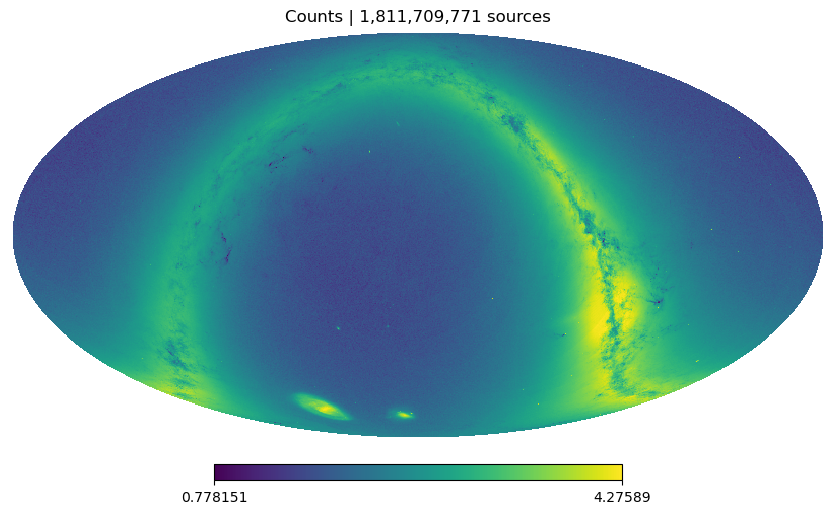

In [15]:
%%time
m = lsdb.compute_skymap(ldf)
hp.mollview(np.log10(m+1), title=f'Counts | {m.sum():,.0f} sources', nest=True)

In [7]:
# some debugging
gaiacsv = glob.glob("/epyc/data/gaia_dr3/csv/GaiaSource/GaiaSource_*.csv.gz")[-200:]
ddf = dd.read_csv(gaiacsv, comment="#", blocksize=None, dtype={'phot_proc_mode': 'float64'})
m = lsdb.compute_skymap(ddf)
#m.visualize()

## Individual tests
### Pixel-wrangling functions

In [10]:
# test computing the hcidx
import hipscat as hc

try:
    df_orig
except NameError:
    df_orig = pd.read_parquet(f'{inprefix}/Norder2/Npix65/catalog.parquet')
dff = df_orig.copy().iloc[:5]
dff["_ID"] = hc.compute_hcidx(dff["ra"].values, dff["dec"].values)
dff.set_index("_ID", inplace=True)
dff.sort_index(inplace=True)

dff.iloc[:10][["ra", "dec"]]

ra        dec
_ID                                      
4683743707272314880  11.264255 -29.980008
4683743729093181440  11.255093 -29.976936
4683743968771440640  11.280663 -29.960359
4737483338421370880   4.655083 -15.329481
4753396986173980672  13.173931 -11.254662

Partitioning function

3145728


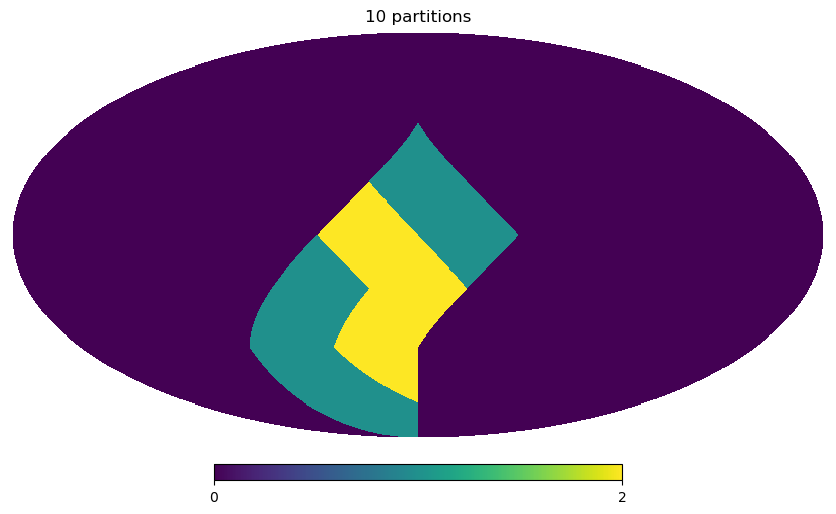

In [13]:
m = np.load("/epyc/projects3/mjuric_hipscat/counts.npy")

opix, orders = hc.compute_partitioning(m)
assert opix[0].dtype == np.uint64

nparts = sum(map(len, opix.values()))
hp.mollview(orders, title=f'{nparts:,.0f} partitions', nest=True)
print(len(orders))

Test the conversion of MOC to orders map

192


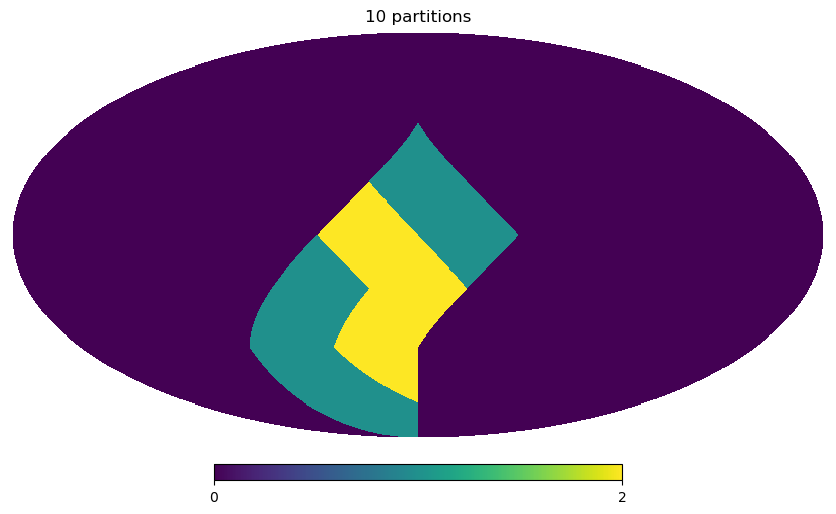

In [14]:
mm = hc.moc2orders(opix)
print(len(mm))
nparts = sum(map(len, opix.values()))
hp.mollview(mm, title=f'{nparts:,.0f} partitions', nest=True)

Test that binning of ra/dec to maps works

In [16]:
df = pd.read_parquet(f'{inprefix}/Norder2/Npix65/catalog.parquet', columns=["ra", "dec"])
m = hc.counts_histogram(df["ra"].values, df["dec"].values, 10)
print(len(m))

12582912


Test building the counts map from a dask dataframe

[########################################] | 100% Completed | 530.05 ms
[########################################] | 100% Completed | 531.11 ms
3145728


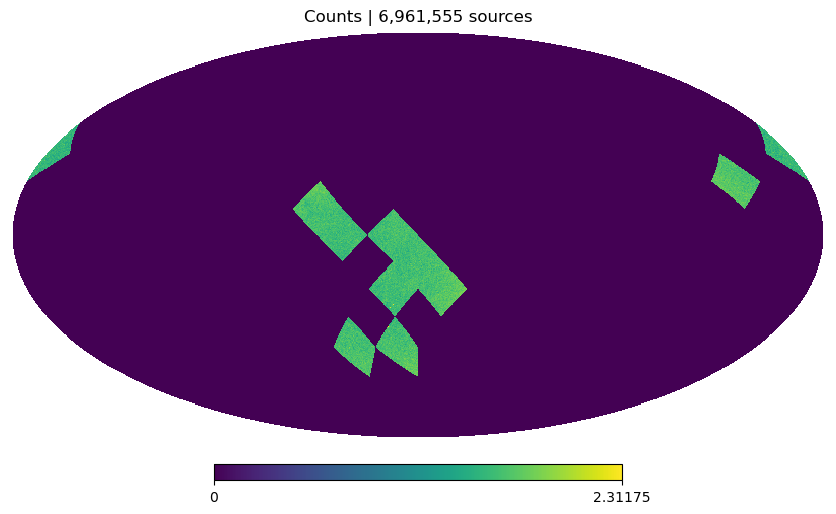

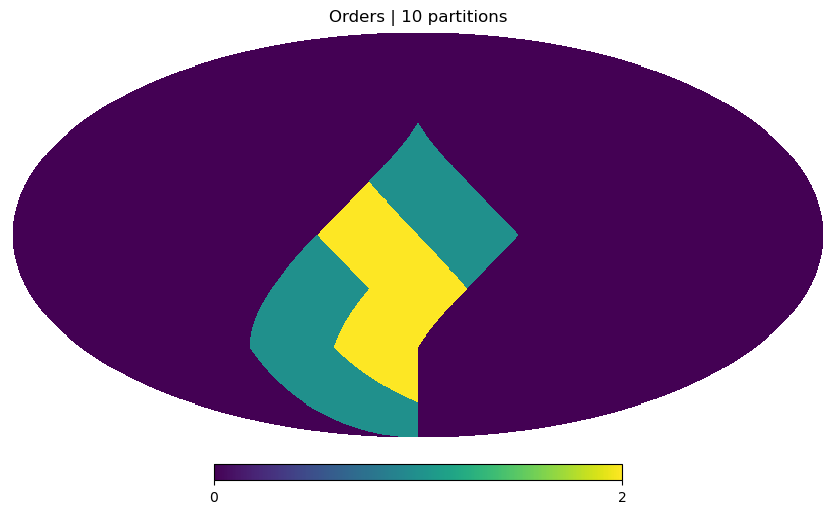

In [19]:
import lsdb

incat = glob.glob(f'{inprefix}/*/*/catalog.parquet')
ddf = dd.read_parquet(incat[:10], columns=["ra", "dec"])

m = lsdb.compute_skymap(ddf, compute=True)
opix, orders = hc.compute_partitioning(m)

if True:
    print(len(m))
    hp.mollview(np.log10(m+1), title=f'Counts | {m.sum():,.0f} sources', nest=True)

if True:
    nparts = sum(map(len, opix.values()))
    hp.mollview(orders, title=f'Orders | {nparts:,.0f} partitions', nest=True)

if True:
    np.save("/epyc/projects3/mjuric_hipscat/counts.npy", m)

Test HCMetadata class:

In [20]:
hcmeta = hc.HCMetadata.from_skymap(m)
print(hcmeta)
print(repr(hcmeta.compute_divisions()))

{'opix': {0: array([0, 2, 6], dtype=uint64), 2: array([ 65,  66,  67,  69,  70, 137, 138], dtype=uint64)}, 'threshold': 1000000, 'lon': 'ra', 'lat': 'dec', 'orders': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint64)}
array([                   0,  2305843009213693952,  4683743612465315840,
        4755801206503243776,  4827858800541171712,  4971973988617027584,
        5044031582654955520,  691

Test conversion from parquet to hipscat:

[0, 2305843009213693952, 4683743612465315840, 4755801206503243776, 4827858800541171712, 4971973988617027584, 5044031582654955520, 6917529027641081856, 9871890383196127232, 9943947977234055168, 18446744073709551615]


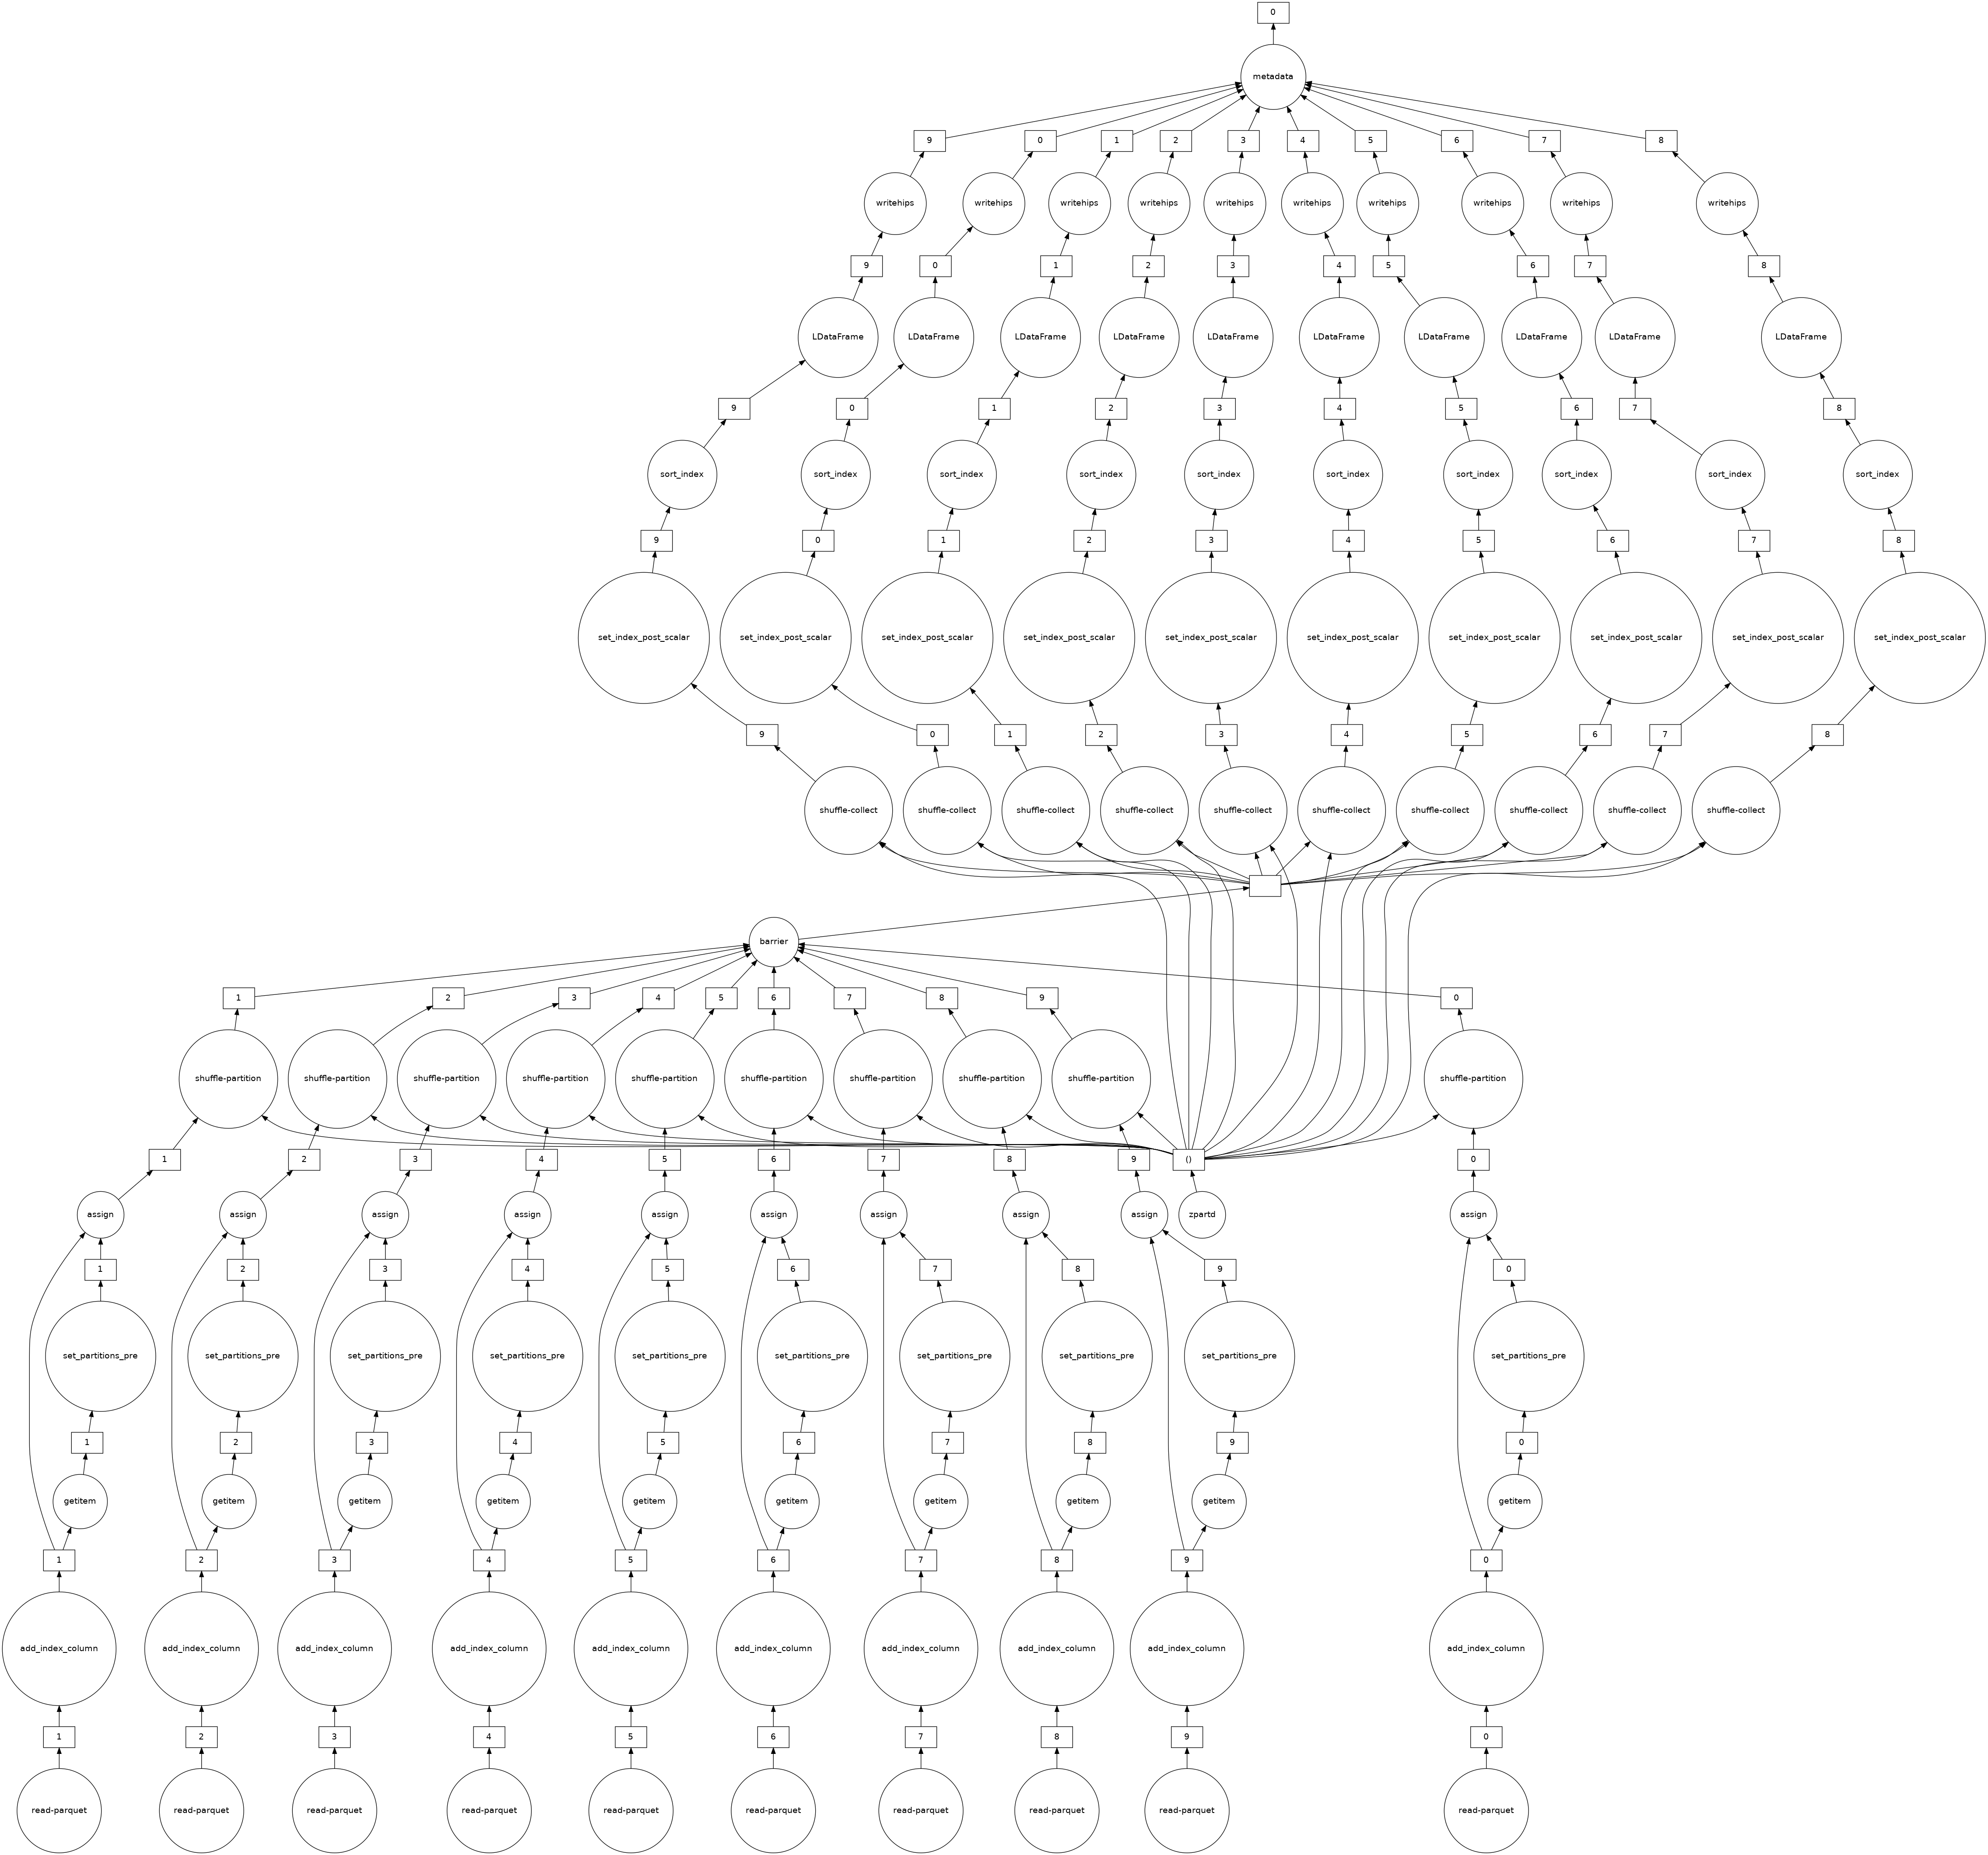

In [28]:
! rm -fr "{outprefix}"

ddf = dd.read_parquet(incat[:10], columns=["ra", "dec"])
ldf = lsdb.from_dask_dataframe(ddf, hcmeta)
graph = ldf.to_hipscat(outprefix, compute=False)
graph.visualize()

Now actually execute:

In [31]:
graph.compute()

[########################################] | 100% Completed | 2.43 ss
[########################################] | 100% Completed | 2.53 s


{'opix': {0: [0, 2, 6], 2: [65, 66, 67, 69, 70, 137, 138]}, 'threshold': 1000000, 'lon': 'ra', 'lat': 'dec', 'orders': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint64)}

Now let's test loading from hipscat. First check we can load the metadata:

In [32]:
hc.HCMetadata.from_hipscat("/epyc/projects3/mjuric_hipscat/foo")

{'opix': {0: array([0, 2, 6], dtype=uint64), 2: array([ 65,  66,  67,  69,  70, 137, 138], dtype=uint64)}, 'threshold': 1000000, 'lon': 'ra', 'lat': 'dec', 'orders': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint64)}

In [33]:
tuple(hcmeta.compute_divisions())

(0,
 2305843009213693952,
 4683743612465315840,
 4755801206503243776,
 4827858800541171712,
 4971973988617027584,
 5044031582654955520,
 6917529027641081856,
 9871890383196127232,
 9943947977234055168,
 18446744073709551615)

Test reading hipscat:

In [34]:
df = lsdb.read_hipscat("/epyc/projects3/mjuric_hipscat/foo", columns=['ra', 'dec'])
print(f"ndivisions={len(df.divisions)}: {df.divisions[:5]} ...")
assert df.divisions and df.divisions[0] is not None
print(len(df))
type(df)

ndivisions=11: (0, 2305843009213693952, 4683743612465315840, 4755801206503243776, 4827858800541171712) ...
[########################################] | 100% Completed | 385.34 ms
[########################################] | 100% Completed | 484.37 ms
6961555


lsdb.core.LSDBDaskDataFrame

Test that Dask Pandas-like operations work:

In [35]:
df[df["ra"] > 10].compute()

[########################################] | 100% Completed | 571.03 ms
[########################################] | 100% Completed | 612.19 ms


ra        dec
_ID                                       
12484345856           44.996155   0.005615
116614234112          45.004978   0.019880
118561439744          45.004320   0.021048
648845197312          44.995037   0.038152
751496593408          44.963896   0.043595
...                         ...        ...
10016004521694593024  11.242555 -30.073218
10016004568852201472  11.262679 -30.064526
10016004596576550912  11.263623 -30.060752
10016004818840059904  11.282907 -30.049970
10016004996297916416  11.263038 -30.034083

[5700818 rows x 2 columns]

## Test the usability of LSDBDaskDataFrame objects

In [36]:
type(ldf[["ra"]])

lsdb.core.LSDBDaskDataFrame

Why doesn't this return a LSDBDaskDataFrame?

In [37]:
type(ldf.query("ra > 100"))

dask.dataframe.core.DataFrame

## Demo

In [38]:
# Figure out the ideal partitioning
incat = glob.glob(f'{inprefix}/*/*/catalog.parquet')[:10]
ddf = dd.read_parquet(incat, columns=["ra", "dec"])
m = lsdb.compute_skymap(ddf)
opix, orders = hc.compute_partitioning(m)
hcmeta = hc.HCMetadata.from_skymap(m)

# Create and write the full catalog
! rm -fr "{outprefix}"

ddf = dd.read_parquet(incat)
ldf = lsdb.from_dask_dataframe(ddf, hcmeta)
ldf.to_hipscat(outprefix)

[########################################] | 100% Completed | 600.62 ms
[########################################] | 100% Completed | 674.00 ms
[0, 2305843009213693952, 4683743612465315840, 4755801206503243776, 4827858800541171712, 4971973988617027584, 5044031582654955520, 6917529027641081856, 9871890383196127232, 9943947977234055168, 18446744073709551615]
[########################################] | 100% Completed | 118.72 s
[########################################] | 100% Completed | 118.82 s


{'opix': {0: [0, 2, 6], 2: [65, 66, 67, 69, 70, 137, 138]}, 'threshold': 1000000, 'lon': 'ra', 'lat': 'dec', 'orders': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint64)}

In [31]:
! du -kh /epyc/projects3/mjuric_hipscat/foo

369M	/epyc/projects3/mjuric_hipscat/foo/Norder0/Npix0
397M	/epyc/projects3/mjuric_hipscat/foo/Norder0/Npix2
283M	/epyc/projects3/mjuric_hipscat/foo/Norder0/Npix6
1.1G	/epyc/projects3/mjuric_hipscat/foo/Norder0
328M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix65
395M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix66
322M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix69
339M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix67
333M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix70
374M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix138
355M	/epyc/projects3/mjuric_hipscat/foo/Norder2/Npix137
2.4G	/epyc/projects3/mjuric_hipscat/foo/Norder2
3.5G	/epyc/projects3/mjuric_hipscat/foo


## The kind of Construction API I've been aiming for...

Ideally, I'd really like this:

In [ ]:
incat = glob.glob(f'{inprefix}/*/*/catalog.parquet')
ddf = dd.read_parquet(incat)

ldf = from_dask_dataframe(ddf, ra_col="ra", dec_col="dec", threshold=1_000_000)
ldf.to_hipscat("/epyc/projects3/mjuric_hipscat/foo")

but can't quite figure out yet how to pack all of this into a single task graph...

This is where I am right now:

In [ ]:
# General note: the data source should _always_ be a DaskDataFrame.

# Figure out the ideal partitioning
incat = glob.glob(f'{inprefix}/*/*/catalog.parquet')
ddf = dd.read_parquet(incat, columns=["ra", "dec"])
partitioning = create_partitioning(ddf)

# Create and write the full catalog
ddf = dd.read_parquet(incat)
ldf = from_dask_dataframe(ddf, partitioning)
ldf.to_hipscat("/epyc/projects3/mjuric_hipscat/foo")